# Fox Survey Data

## Importing the Data
Tried to import via the API using [QualtricsAPI](https://www.qualtricsapi-pydocs.com/installation.html). I think this may not work cause Jin is the owner of the survey.
 
- _Note_: `sub-074` was mislabeled in the pre-test as `sub-073`. For now, I'm manually changing that in the raw data before importing it into the notebook.

In [1]:
import pandas as pd
import datetime as dt
import os

In [2]:

data_dir = os.path.abspath(os.path.join(os.getcwd(), '../data/surveys'))
today = dt.date.today()
date = today #.replace(day=today.day-1) #yesterday's data, change as needed

# as long as you remove the time from the datasheet (##.##.csv), you don't need to manually change anything
pre_filename = f'fox-pre_{date.strftime("%B")} {date.strftime("%-d")}, {date.strftime("%Y")}.csv' 
post_filename = f'fox-post_{date.strftime("%B")} {date.strftime("%-d")}, {date.strftime("%Y")}.csv' 

pre = pd.read_csv(os.path.join(data_dir, pre_filename), skiprows=[1,2], encoding='utf-8-sig', parse_dates=[1,2], dayfirst=False)
post = pd.read_csv(os.path.join(data_dir, post_filename), skiprows=[1,2], encoding='utf-8-sig', parse_dates=[1,2], dayfirst=False)


/var/folders/4z/r7mkx_mj2d73zrgl4w0848ww0000gq/T/ipykernel_54446/4153165684.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pre = pd.read_csv(os.path.join(data_dir, pre_filename), skiprows=[1,2], encoding='utf-8-sig', parse_dates=[1,2], dayfirst=False)


## Demographics

In [3]:
import numpy as np

In [4]:
conditions = {'LEGO':1, 'BIG MOOD':2, 'American Pickers':3, 
              'CNN News':4, 'Continental':5, 'Fox News':6, 
              'NFL':7, 'YouTube TV':8, 'Smartphone A':12,
              'Smartphone B':10, 'Control TV':11, 'Control Smartphone':13}
conditions_swap = {v: k for k, v in conditions.items()}

post['Cond'] = post['condition'].map(conditions_swap)
pre['Cond'] = pre['condition'].map(conditions_swap)

In [5]:
demos = post[['id', 'Cond', 'condition', 'gender', 'age', 'glasses', 'race', 'education', 'income', 'politics']].copy()
demos['F'] = np.where(demos['gender']==2, 1,0)

demo_sum = demos.groupby('Cond').agg({
    'condition': ['size'],
    'age': ['min', 'mean', 'max'],
    'F': ['sum']
}).round(2)

demo_sum

condition age              F
                        size min   mean max sum
Cond                                           
American Pickers           7  18  20.57  24   7
BIG MOOD                   9  18  22.00  25   6
CNN News                   7  18  19.57  22   6
Continental                7  18  24.57  47   4
Control Smartphone        18  18  24.00  70  13
Control TV                 8  18  30.50  47   7
Fox News                   8  18  26.50  49   7
LEGO                       8  19  29.25  66   6
NFL                        7  18  22.86  29   4

In [6]:
import matplotlib.pyplot as plt

(0.0, 10.0)

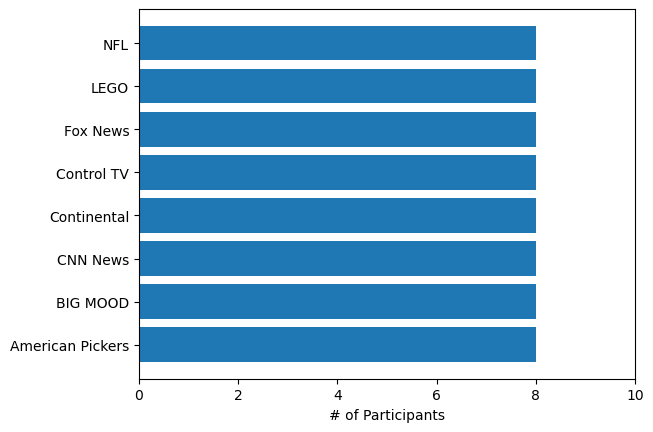

In [7]:
demo_sum_flat = pd.DataFrame(demo_sum.to_records())
#plt.bar(demo_sum_flat.iloc[:,1], demo_sum_flat['Cond'])
#plt.xticks(rotation=90)
#plt.xlabel('# of Participants')

fix, ax = plt.subplots()
hbars = ax.barh(demo_sum_flat.loc[demo_sum_flat["Cond"]!='Control Smartphone', "Cond"], demo_sum_flat.iloc[-4,1])
ax.set_xlabel('# of Participants')
ax.set_xlim(right=10)

## Rejectors
A lot of rejectors in this group for Fox Sports and Fox News. Some still made their way into the condition they're a rejector of.

In [6]:
rejectors = pre[['sub_id', 'Cond', 'condition', 'rejector_FOX-Prime', 'rejector_FOX-Sports', 'rejector_FOX-News']].copy()

In [7]:
rejectors[['rejector_FOX-Prime', 'rejector_FOX-Sports', 'rejector_FOX-News']].describe()

,rejector_FOX-Prime,rejector_FOX-Sports,rejector_FOX-News
count,77,77,77
unique,2,2,2
top,False,True,True
freq,50,39,61


In [8]:
prime_miss = (rejectors['rejector_FOX-Prime']==True) & (rejectors['Cond']=='LEGO')
sports_miss = (rejectors['rejector_FOX-Sports']==True) & (rejectors['Cond']=='NFL')
news_miss = (rejectors['rejector_FOX-News']==True) & (rejectors['Cond']=='Fox News')

rejectors['miss'] = np.where(prime_miss|sports_miss|news_miss,True,False)
rejectors[(rejectors['miss']==True)]

,sub_id,Cond,condition,rejector_FOX-Prime,rejector_FOX-Sports,rejector_FOX-News,miss
24,sub-025,NFL,7.0,False,True,False,True
26,sub-027,LEGO,1.0,True,False,True,True
31,sub-032,Fox News,6.0,True,True,True,True
32,sub-033,NFL,7.0,True,True,True,True
34,sub-035,LEGO,1.0,True,True,True,True
43,sub-044,LEGO,1.0,True,True,True,True
69,sub-070,Fox News,6.0,False,False,True,True
71,sub-071,Fox News,6.0,False,True,True,True
73,sub-074,Fox News,6.0,False,True,True,True


# Willingness To Pay

## Data Cleaning
Thank you ChatGPT.

In [27]:
wtp = post.filter(regex='id|Cond|wtp')
wtp_t = post.filter(regex='id|Cond|wtp')

In [28]:
import re

# Function to convert strings with non-numeric characters to float
def convert_to_number(value):
    if isinstance(value, str):
        # Remove non-numeric except period and minus
        cleaned_value = re.sub(r'[^\d.-]', '', value)
        # Convert to float if possible, else 0
        try:
            return float(cleaned_value)
        except ValueError:
            return 0.0
    else:
        return float(value)

In [29]:
# Columns to clean
wtp_columns = [col for col in wtp.columns if 'wtp' in col]

# Apply the conversion
for col in wtp_columns:
    wtp[col] = wtp[col].apply(convert_to_number)

# Show the cleaned data and check types
wtp[wtp_columns].head(), wtp[wtp_columns].dtypes

/var/folders/4z/r7mkx_mj2d73zrgl4w0848ww0000gq/T/ipykernel_54446/4150799468.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wtp[col] = wtp[col].apply(convert_to_number)


(   1_wtp_1  2_wtp_1  3_wtp_1  4_wtp_1  5_wtp_1  6_wtp_1  7_wtp_1  8_wtp_1
 0     30.0     20.0     10.0   1000.0     10.0      5.0  30000.0     10.0
 1      0.0      0.0      0.0    200.0     10.0      0.0      0.0      0.0
 2     50.0    100.0     10.0    300.0     15.0      5.0  20000.0     20.0
 3      1.0      3.0      3.0      2.0     13.0      8.0  80000.0    800.0
 4     10.0      0.0     10.0   1000.0     10.0      3.0  50000.0     20.0,
 1_wtp_1    float64
 2_wtp_1    float64
 3_wtp_1    float64
 4_wtp_1    float64
 5_wtp_1    float64
 6_wtp_1    float64
 7_wtp_1    float64
 8_wtp_1    float64
 dtype: object)

In [30]:
column_name_mapping = {
    '1_wtp_1': 'Tracfone_wtp',
    '2_wtp_1': 'Rakuten_wtp',
    '3_wtp_1': 'Paramount_wtp',
    '4_wtp_1': 'Samsung_wtp',
    '5_wtp_1': 'BurgerKing_wtp',
    '6_wtp_1': 'RedBull_wtp',
    '7_wtp_1': 'Chevrolet_wtp',
    '8_wtp_1': 'Lilly_wtp'
}

wtp.rename(columns=column_name_mapping, inplace=True)

/var/folders/4z/r7mkx_mj2d73zrgl4w0848ww0000gq/T/ipykernel_54446/905535020.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wtp.rename(columns=column_name_mapping, inplace=True)


In [31]:
wtp_filename = f'fox-wtp_{date.strftime("%B")} {date.strftime("%-d")}, {date.strftime("%Y")}.csv' 
wtp.to_csv(os.path.join(data_dir, wtp_filename))

# Scratch

In [28]:
# how many subjects in each condition
post['Cond'] = post['condition'].map(conditions_swap)
post[['Cond']].groupby('Cond').size()

# average age per group
post.groupby('Cond')[['age']].mean().round(2)

# can we put these together
post.groupby(['Cond', 'gender']).agg({
    'condition': ['size'],
    'age': [min, 'mean', max]
}).round(2)

Cond
American Pickers       3
BIG MOOD               3
CNN News               3
Continental            3
Control Smartphone    18
Control TV             2
Fox News               2
LEGO                   3
NFL                    2
dtype: int64